In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy import stats
import scipy
from scipy.stats import chi2
import autokeras as ak

In [2]:
import logging

logging.basicConfig(level = logging.INFO)
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)

In [85]:
exposure = ''
data_selection = 1

model_DU = tf.keras.models.load_model('./models_lowE/models_PoissonTrain/0910{}_1_1_1.h5'.format(exposure))
if exposure == '': data = dict(np.load('/home/ML4NO/Data/sample_ML_classification.npz'))
else: data = dict(np.load('/home/ML4NO/Data/sample_ML_classification_{}.npz'.format(exposure)))
data['cpv'][0] = 0

if data_selection == 0:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif data_selection == 1:
    data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
elif data_selection == 2:
    data_all = np.column_stack([data['ve_dune'][:,36:], data['vu_dune'][:,36:], data['vebar_dune'][:,36:], data['vubar_dune'][:,36:]])

In [59]:
cpc_label = np.where(data['cpv'] == 0)[0]
data_gen_mpi = np.random.poisson(data_all[cpc_label[0]], size = (100000, 144))
data_gen_0 = np.random.poisson(data_all[cpc_label[1]], size = (100000, 144))
data_gen_pi = np.random.poisson(data_all[cpc_label[2]], size = (100000, 144))

prediction_DU_mpi = model_DU.predict(data_gen_mpi)
prediction_DU_0 = model_DU.predict(data_gen_0)
prediction_DU_pi = model_DU.predict(data_gen_pi)

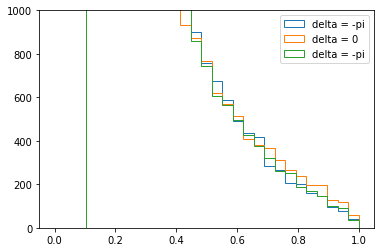

In [61]:
bins = np.linspace(0, 1, 30)
plt.hist(prediction_DU_mpi, bins=bins, histtype='step', label = 'delta = -pi')
plt.hist(prediction_DU_0, bins=bins, histtype='step', label = 'delta = 0')
plt.hist(prediction_DU_pi, bins=bins, histtype='step', label = 'delta = -pi')
plt.ylim((0,1000))
plt.legend()
plt.show()

In [73]:
chi_arr = []
gen = 10000

for i, angle in enumerate(data['delta']):
    data_gen = np.random.poisson(data_all[i], size = (10000, 144))
    prediction_DU = model_DU.predict(data_gen)
    if -89 <= angle <= 89: pvalue = (prediction_DU_0 > np.median(prediction_DU)).sum()
    elif angle > 89: pvalue = (prediction_DU_pi > np.median(prediction_DU)).sum()
    else: pvalue = (prediction_DU_mpi > np.median(prediction_DU)).sum()
    pvalue /= gen
    chi_square = chi2.ppf(1-2*pvalue,1)
    chi_arr.append(chi_square)

In [94]:
exposure_list = ['p25', 'p5', '', 't2', 't4']
chi_arr_list = []

for exposure in exposure_list:
    data_selection = 1

    model_DU = tf.keras.models.load_model('./models_lowE/models_PoissonTrain/0910{}_1_1_1.h5'.format(exposure))
    if exposure == '': data = dict(np.load('/home/ML4NO/Data/sample_ML_classification.npz'))
    else: data = dict(np.load('/home/ML4NO/Data/sample_ML_classification_{}.npz'.format(exposure)))
    data['cpv'][0] = 0

    if data_selection == 0:
        data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
    elif data_selection == 1:
        data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
    elif data_selection == 2:
        data_all = np.column_stack([data['ve_dune'][:,36:], data['vu_dune'][:,36:], data['vebar_dune'][:,36:], data['vubar_dune'][:,36:]])
        
    cpc_label = np.where(data['cpv'] == 0)[0]
    data_gen_mpi = np.random.poisson(data_all[cpc_label[0]], size = (100000, 144))
    data_gen_0 = np.random.poisson(data_all[cpc_label[1]], size = (100000, 144))
    data_gen_pi = np.random.poisson(data_all[cpc_label[2]], size = (100000, 144))

    prediction_DU_mpi = model_DU.predict(data_gen_mpi)
    prediction_DU_0 = model_DU.predict(data_gen_0)
    prediction_DU_pi = model_DU.predict(data_gen_pi)

    chi_arr = []
    gen = 10000

    for i, angle in enumerate(data['delta']):
        data_gen = np.random.poisson(data_all[i], size = (gen, 144))
        prediction_DU = model_DU.predict(data_gen)
        if -89 <= angle <= 89: pvalue = (prediction_DU_0 > np.median(prediction_DU)).sum()
        elif angle > 89: pvalue = (prediction_DU_pi > np.median(prediction_DU)).sum()
        else: pvalue = (prediction_DU_mpi > np.median(prediction_DU)).sum()
        pvalue /= gen
        chi_square = chi2.ppf(1-2*pvalue,1)
        chi_arr.append(chi_square)
    chi_arr_list.append(chi_arr)

In [112]:
np.array(chi_arr_list).shape

(5, 425)

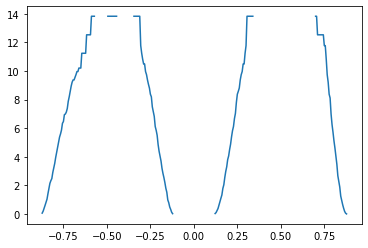

In [114]:
plt.plot(data2['delta']/180, chi_arr_list[1])

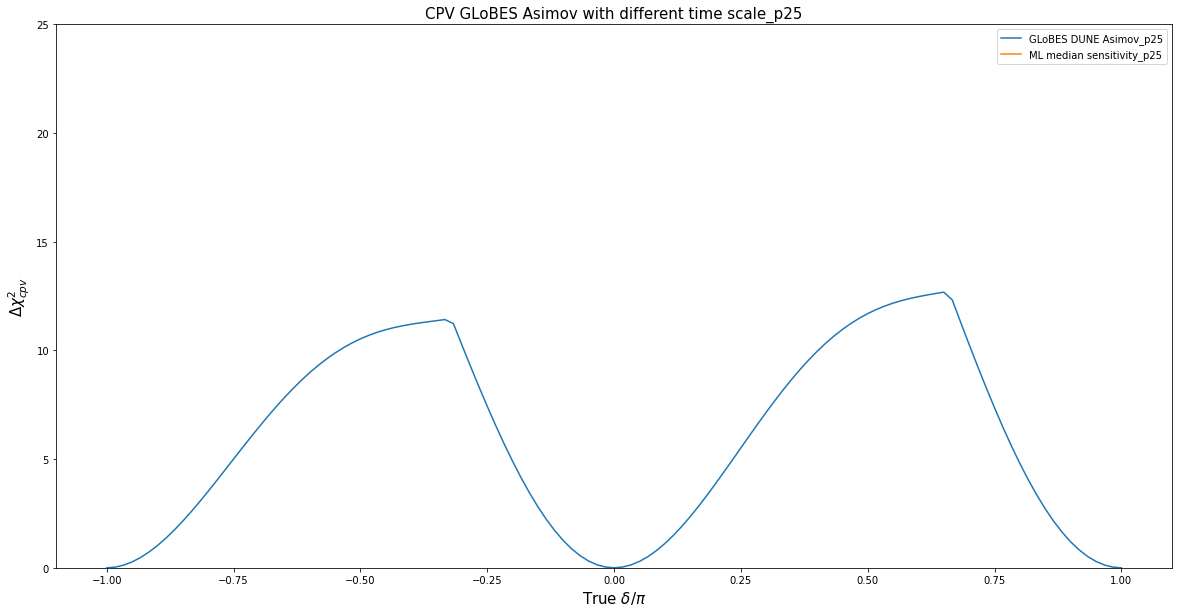

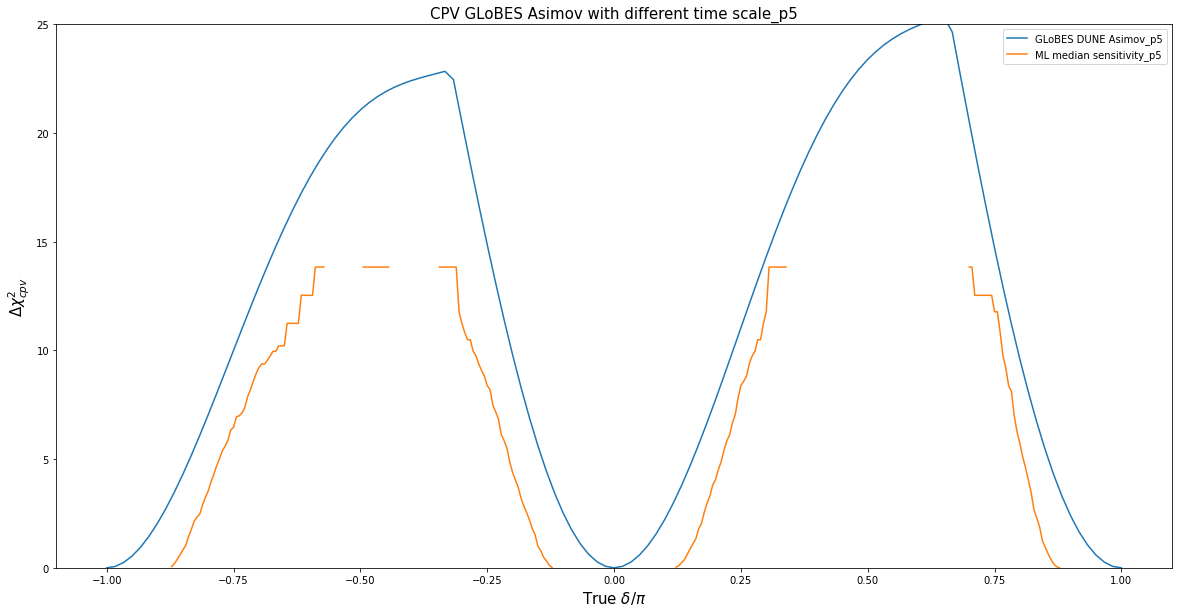

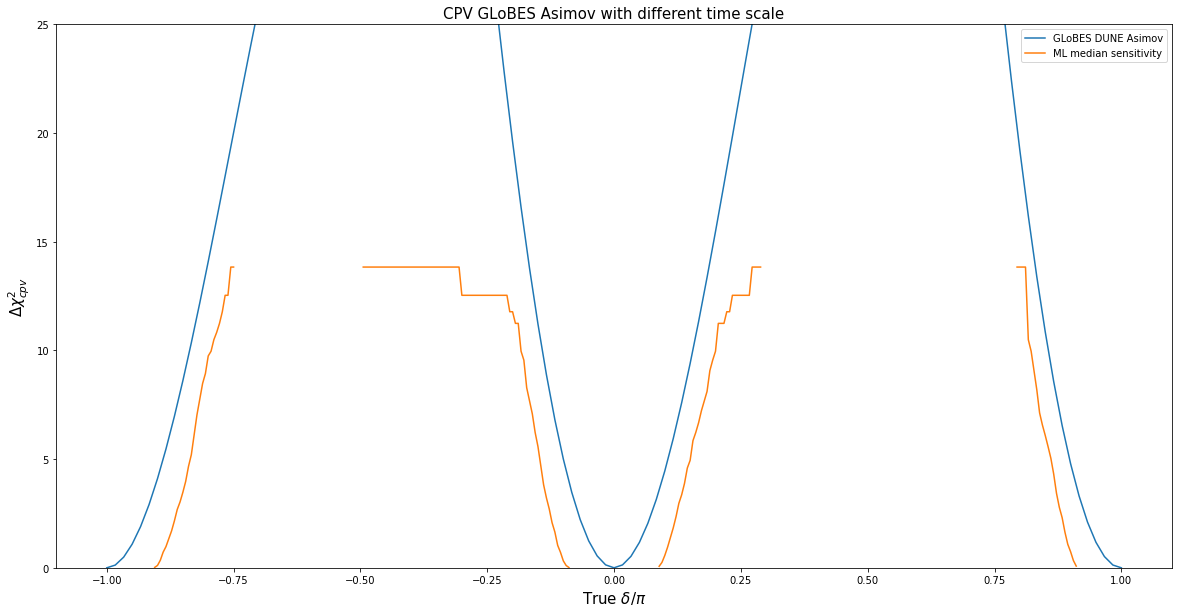

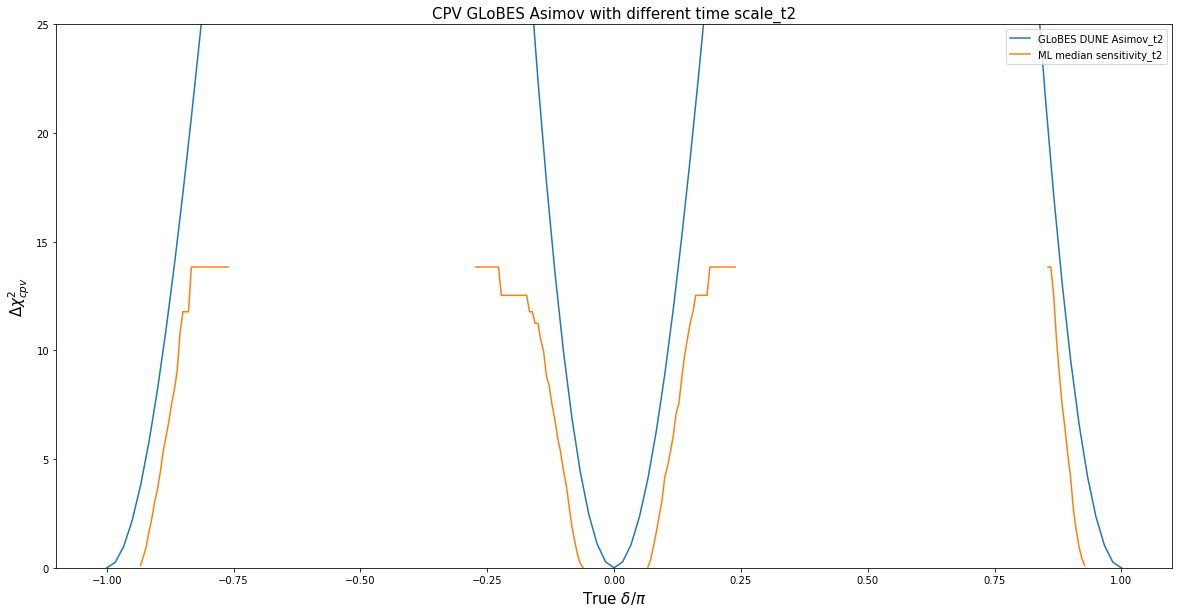

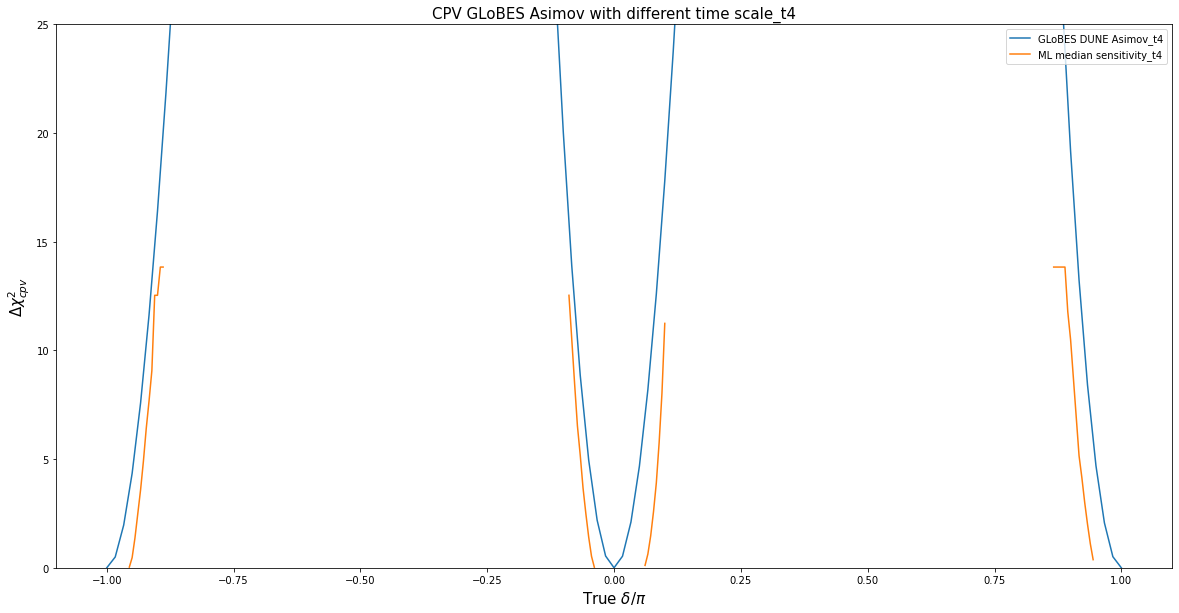

In [115]:
exposure_list = ['_p25', '_p5', '', '_t2', '_t4']

for i, ex in enumerate(exposure_list):
    plt.figure(figsize = (20,10))
    data = np.load('/home/ML4NO/Data/cpv_sensitivity_globes{}.npz'.format(ex))
    if exposure == '': data2 = dict(np.load('/home/ML4NO/Data/sample_ML_classification.npz'))
    else: data2 = dict(np.load('/home/ML4NO/Data/sample_ML_classification{}.npz'.format(ex)))

    plt.plot(data['delta_cp']/180, data['OFF_DU'], label='GLoBES DUNE Asimov{}'.format(ex))
    plt.plot(data2['delta']/180, chi_arr_list[i], label ='ML median sensitivity{}'.format(ex))
    plt.title('CPV GLoBES Asimov with different time scale{}'.format(ex), fontsize=15)
    plt.xlabel(r'True $\delta / \pi $', fontsize=15)
    plt.ylabel(r'$\Delta\chi^2_{cpv} $', fontsize=15)
    plt.ylim(0, 25)
    plt.legend()
    plt.show()